In [1]:
import os
import netCDF4 as nc
import numpy as np
from mcnsh import mcnormspatialhet
from nsh import normalizedspatialhet

output_path = '/data/nriemer/d/sf20/les_output/wrf-partmc'
# 1934602 basecase, corrected IC aitken mode geom mean diam, corrected IC gas concentrations, tstart 2023-03-20_09:00:00
basecase_subdir = os.path.join(output_path, 'slurm-1934602')
basecase_aerodata = nc.Dataset(os.path.join(basecase_subdir, 'aerosols_d01_2023-03-20_09:00:00'))
basecase_aerodistdata = nc.Dataset(os.path.join(basecase_subdir, 'aerosol_dist_d01_2023-03-20_09:00:00'))

# 1935061, corrected gas emission scaling, corrected IC aitken mode geom mean diam, corrected IC gas concentrations, tstart 2023-03-20_09:00:00
pointsource10x10_subdir = os.path.join(output_path, 'slurm-1935061') # aerosol ICs everywhere, emissions follow SH patttern
pointsource10x10_aerodata = nc.Dataset(os.path.join(pointsource10x10_subdir, 'aerosols_d01_2023-03-20_09:00:00'))
pointsource10x10_aerodistdata = nc.Dataset(os.path.join(pointsource10x10_subdir, 'aerosol_dist_d01_2023-03-20_09:00:00'))

global aerodata_dict
global nsh_dict

aerodata_dict = {'basecase': {'aerodata': basecase_aerodata,
                              'distdata': basecase_aerodistdata,
                              },
                 'point-source-10x10': {'aerodata': pointsource10x10_aerodata,
                                 'distdata': pointsource10x10_aerodistdata,
                                 },
                }

nsh_dict = {'basecase': {},
            'point-source-10x10': {},
            }

n_times = basecase_aerodata.dimensions['Time'].size
n_levels = basecase_aerodata.dimensions['bottom_top'].size
domain_x_cells = basecase_aerodata.dimensions['west_east'].size
domain_y_cells = basecase_aerodata.dimensions['south_north'].size

global boxplot_data
boxplot_data = {}


def createEmissionsNSHDict():
    parent_dir = '/data/keeling/a/sf20/b/wrf-partmc-spatial-het/WRFV3/test/em_les'
    shdir = 'spatial-het/sh-patterns'
    griddir = f'xres{domain_x_cells}yres{domain_y_cells}'

    basecase_filename = 'uniform-basecase.csv'
    basecase_array_path = os.path.join(parent_dir, shdir, griddir, basecase_filename)
    basecase_arr = np.genfromtxt(basecase_array_path, delimiter=',')

    emissions_nsh_dict = {}
    for filename in os.listdir(os.path.join(parent_dir, shdir, griddir)):
        if filename == 'fx0fy0.csv':
            continue
        scenario = filename.replace('.csv', '')
        array_path = os.path.join(parent_dir, shdir, griddir, filename)
        scenario_arr = np.genfromtxt(array_path, delimiter=',')
        scaling_factor = basecase_arr.sum() / scenario_arr.sum()
        scenario_arr = scaling_factor*scenario_arr
        #arr_nsh = mcnormspatialhet(scenario_arr, n_permutes=100000)
        arr_nsh = normalizedspatialhet(scenario_arr)
        emissions_nsh_dict[scenario] = arr_nsh
        #print(f'{scenario}, scaling factor = {scaling_factor}, NSH = {arr_nsh:4.3f}')
    emissions_nsh_dict = dict(sorted(emissions_nsh_dict.items(), key=lambda item: item[1]))

    return emissions_nsh_dict

def convertMassConctoVolumeMixingRatio(scenario_data, species_name, species_molar_weight):

    dry_air_molar_weight = 28.9644 # g/mol
    inverse_airdens = scenario_data['ALT'][:]
    MMR = inverse_airdens*scenario_data[species_name][:] # mass mixing ratio of species
    VMR = 1e6*(dry_air_molar_weight/species_molar_weight)*MMR # Volume mixing ratio in ppmv
    # need to multiply by 1e6 to convert from mol ammonium / mol air to micromol
    return VMR

def calculateNSHTimeSlice(scenario, variable):
    scenario_aerodata = aerodata_dict[scenario]['aerodata']
    
    levels = np.arange(n_levels)
    times = np.arange(n_times)
    nsh_array = np.zeros((n_times, n_levels))
    for itime in times:
        for ilevel in levels:
            level_array = scenario_aerodata[variable][itime, ilevel, :, :]
            nsh_estimate = mcnormspatialhet(level_array, n_permutes=10000)
            nsh_array[itime, ilevel] = nsh_estimate
    
    nsh_dict[scenario][variable] = nsh_array
    return nsh_array

def calculateVarZT(scenario, variable, mixingratio=True):
    levels = np.arange(n_levels)
    times = np.arange(n_times)

    var_array = np.zeros((n_times, n_levels))
    for itime in times:
        for ilevel in levels:
            if mixingratio:
                inverse_airdens = aerodata_dict[scenario]['aerodata']['ALT'][itime, ilevel, :, :]
                level_array = inverse_airdens*aerodata_dict[scenario]['aerodata'][variable][itime, ilevel, :, :]
            else:
                level_array = aerodata_dict[scenario]['aerodata'][variable][itime, ilevel, :, :]
            var_array[itime, ilevel] = level_array.mean()
    return var_array

def calculateVarPercentDiff(scenario, variable,  mixingratio=False, skip_t0=False):
    array_scenario = calculateVarZT(scenario, variable, mixingratio)
    array_basecase = calculateVarZT('basecase', variable, mixingratio)

    if skip_t0:
        array_scenario = array_scenario[1:]
        array_basecase = array_basecase[1:]

    rel_diff = 100*(array_scenario - array_basecase)/array_basecase
    return rel_diff

def calculateVarBias(scenario, variable,  mixingratio=False, skip_t0=False):
    array_scenario = calculateVarZT(scenario, variable, mixingratio)
    array_basecase = calculateVarZT('basecase', variable, mixingratio)

    if skip_t0:
        array_scenario = array_scenario[1:]
        array_basecase = array_basecase[1:]

    bias = (array_scenario - array_basecase)
    return bias

def calcTotConcZT(scenario, dist_type, min_particle_size):
    n_bins = 100
    bins = np.arange(n_bins)
    times = np.arange(n_times)

    #scenario_aerodata = aerodata_dict[scenario]['aerodata']
    scenario_distdata = aerodata_dict[scenario]['distdata']
    xgrid, ygrid, kgrid = 40, 40, 100
    var_array = np.zeros((n_times, kgrid, ygrid, xgrid))

    bin_edges = scenario_distdata['BIN_EDGES'][:].data[0]#scenario_aerodata['BIN_EDGES'][:].data[0]
    bin_centers = scenario_distdata['BIN_CENTERS'][:].data[0]#scenario_aerodata['BIN_CENTERS'][:].data[0]
    bin_width = bin_edges[1:] - bin_edges[:-1]

    for time_idx in times:
        for k in np.arange(kgrid):
            tot_conc = np.zeros((xgrid, ygrid))
            for bin_idx, width, center in zip(bins[1:], bin_width, bin_centers[1:]): 
                # just look at particles larger than 50 nanometers
                if center*1e9 < min_particle_size:
                    continue
                bin_idx += 1 # 1 indexing 
                bin_data = scenario_distdata[f'{dist_type}_a{str(bin_idx).zfill(3)}'][time_idx, k, :, :].data/1e6
                tot_conc += bin_data
            var_array[time_idx, k, :, :] = tot_conc
    var_array_mean = var_array.mean(axis=(2, 3))

    return var_array_mean

def calculateBoxplotData(variable='ccn_001'):
    boxplot_vardata = []
    for scenario_name in emissions_nsh_dict.keys():
        #scenario_nsh = emissions_nsh_dict[scenario_name]
        #scenario_nsh_values.append(scenario_nsh)
        #boxplot_positions.append(round(scenario_nsh, 2))
        #scenario_data = aerodata_dict[scenario_name]['aerodata']
        var_pdiff = calculateVarPercentDiff(scenario=scenario_name, variable=variable, mixingratio=True)
        var_pdiff = var_pdiff[18:36, :65] # previously time 24: (2hrs +)
        boxplot_vardata.append(var_pdiff.flatten())
    boxplot_data[variable] = boxplot_vardata    

emissions_nsh_dict = createEmissionsNSHDict()
scenarios = ['fx2fy2', 'fx1fy1', 'fx1fy0', 'road-double', 'point-source-10x10', 'road-8x', 'road-16x'
             ]
emissions_nsh_dict = {key: value for key, value in emissions_nsh_dict.items() if key in scenarios}

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors
import mpl_toolkits.axes_grid1.inset_locator as il
import matplotlib.patches as patches
import matplotlib.animation as animation
from matplotlib.ticker import FormatStrFormatter
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

def plotNSH(scenario, variable, vmin=None, vmax=None, lognorm=False):
    
    if variable not in nsh_dict[scenario]:
        print(f'{variable} not in NSH dictionary for {scenario}, calculating')
        nsh_array = calculateNSHTimeSlice(scenario, variable)
    else:
        nsh_array = nsh_dict[scenario][variable]

    fig, ax  = plt.subplots(1,1, figsize=(12,5))
    if lognorm:
        norm = mplcolors.LogNorm(vmin, vmax)
    elif ((vmin != None) and (vmax != None)):
        norm = mplcolors.Normalize(vmin, vmax)
    else:
        norm = None
    cs = ax.pcolormesh(nsh_array.T, norm=norm)
    cbar = fig.colorbar(cs, label='NSH')

    ax.set_xlabel('Time (mins)', fontsize=12)
    ax.set_ylabel('z [km]', fontsize=12)
    ax.set_xticks(np.linspace(0, n_times-1, 13))
    ax.set_xticklabels(5*np.linspace(0, n_times-1, 13))
    ax.set_yticks(np.arange(0, n_levels+1, 25))
    ax.set_yticklabels(np.linspace(0, 2, 5).round(2))
    ax.set_title(f'{scenario}, NSH ({variable})')

def plotZT(scenario, variable, vmin=None, vmax=None, lognorm=False, mixingratio=True):
    
    var_array = calculateVarZT(scenario, variable, mixingratio)
    
    fig, ax  = plt.subplots(1,1, figsize=(12,5))
    if lognorm:
        norm = mplcolors.LogNorm(vmin, vmax)
    else:
        norm = None
    cs = ax.pcolormesh(var_array.T, norm=norm)

    if mixingratio:
        var_units = 'mixing ratio'
    else:
        var_units = 'concentration'
    
    cbar = fig.colorbar(cs, label=f'{variable} {var_units}')

    ax.set_xlabel('Time (mins)', fontsize=12)
    ax.set_ylabel('z [km]', fontsize=12)
    ax.set_xticks(np.linspace(0, n_times-1, 13))
    ax.set_xticklabels(5*np.linspace(0, n_times-1, 13))
    ax.set_yticks(np.arange(0, n_levels+1, 25))
    ax.set_yticklabels(np.linspace(0, 2, 5).round(2))
    ax.set_title(f'{scenario}, {variable}')

def plotConcT(scenario, variable, zlevel, vmin=None, vmax=None, lognorm=False, mixingratio=True):
    
    var_array = calculateVarZT(scenario, variable, mixingratio)
    
    fig, ax  = plt.subplots(1,1, figsize=(12,5))
    if lognorm:
        norm = mplcolors.LogNorm(vmin, vmax)
    else:
        norm = None
    cs = ax.pcolormesh(var_array.T, norm=norm)

    if mixingratio:
        var_units = 'mixing ratio'
    else:
        var_units = 'concentration'
    
    cbar = fig.colorbar(cs, label=f'{variable} {var_units}')

    ax.set_xlabel('Time (mins)', fontsize=12)
    ax.set_ylabel('z [km]', fontsize=12)
    ax.set_xticks(np.linspace(0, n_times-1, 13))
    ax.set_xticklabels(5*np.linspace(0, n_times-1, 13))
    ax.set_yticks(np.arange(0, n_levels+1, 25))
    ax.set_yticklabels(np.linspace(0, 2, 5).round(2))
    ax.set_title(f'{scenario}, {variable}')

def plotScenariosVarsLevelConc(scenarios, variables, zlevel, mixingratio):
    #var_array = calculateVarZT(scenario, variable, mixingratio)
    fig, axs  = plt.subplots(len(variables),1, figsize=(12,12))

    for ax, variable in zip(axs, variables):
        for scenario in scenarios:
            times = np.arange(n_times)
            var_array = np.zeros((n_times))
            for itime in times:
                if mixingratio:
                    inverse_airdens = aerodata_dict[scenario]['aerodata']['ALT'][itime, zlevel, :, :]
                    level_array = inverse_airdens*aerodata_dict[scenario]['aerodata'][variable][itime, zlevel, :, :]
                else:
                    level_array = aerodata_dict[scenario]['aerodata'][variable][itime, zlevel, :, :]
                var_array[itime] = level_array.mean()
                

            ax.plot(times, var_array, label = scenario)

        if mixingratio:
            var_units = 'Mixing Ratio'
        else:
            var_units = 'Concentration'

        #cbar = fig.colorbar(cs, label=f'{variable} {var_units}')
        ax.legend()
        ax.set_xlabel('Time (mins)', fontsize=12)
        ax.set_ylabel(f'{var_units}', fontsize=12)
        ax.set_xticks(np.linspace(0, n_times-1, 13))
        ax.set_xticklabels(5*np.linspace(0, n_times-1, 13))
        #ax.set_yticks(np.arange(0, n_levels+1, 25))
        #ax.set_yticklabels(np.linspace(0, 2, 5).round(2))
        ax.set_title(f'{variable}')
    plt.suptitle(f'Z-level: {zlevel}')
    plt.tight_layout()

def plotScenariosVarsVerticalProfile(scenarios, variables, time, mixingratio):
    #var_array = calculateVarZT(scenario, variable, mixingratio)
    fig, axs  = plt.subplots(1,len(variables), figsize=(len(variables)*4,4.5))

    for ax, variable in zip(axs, variables):
        for scenario in scenarios:
            #times = np.arange(n_times)
            var_array = np.zeros((n_times))
            if mixingratio:
                inverse_airdens = aerodata_dict[scenario]['aerodata']['ALT'][time, :, :, :]
                array = inverse_airdens*aerodata_dict[scenario]['aerodata'][variable][time, :, :, :]
            else:
                array = aerodata_dict[scenario]['aerodata'][variable][time, :, :, :]
            
            array_mean = array.mean(axis=(1,2))
                

            ax.plot(array_mean, np.arange(100), label = scenario)

        if mixingratio:
            var_units = 'Mixing Ratio'
        else:
            var_units = 'Concentration'
            if variable in ['TEMPERATURE', 'REL_HUMID']:
                var_units = ''

        #cbar = fig.colorbar(cs, label=f'{variable} {var_units}')
        ax.legend()
        ax.set_xlabel(f'{var_units}', fontsize=12)
        ax.set_ylabel('z [km]', fontsize=12)
        ax.set_yticks(np.arange(0, n_levels+1, 25))
        ax.set_yticklabels(np.linspace(0, 2, 5).round(2))
        ax.set_title(f'{variable}')
    plt.suptitle(f'Time: {5*time} m')
    plt.tight_layout()

def plotNSHPercentDiff(scenario, variable, vmin=None, vmax=None):
    
    if variable not in nsh_dict[scenario]:
        print(f'{variable} not in NSH dictionary for {scenario}, calculating')
        nsh_array_scenario = calculateNSHTimeSlice(scenario, variable)
    else:
        nsh_array_scenario = nsh_dict[scenario][variable]

    if variable not in nsh_dict['basecase']:
        print(f'{variable} not in NSH dictionary for basecase, calculating')
        nsh_array_basecase = calculateNSHTimeSlice('basecase', variable)
    else:
        nsh_array_basecase = nsh_dict['basecase'][variable]
    
    rel_diff = 100*(nsh_array_scenario - nsh_array_basecase)/nsh_array_basecase
    fig, ax  = plt.subplots(1,1, figsize=(12,5))
    cs = ax.pcolormesh(rel_diff.T, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(cs, label='NSH percent difference')

    ax.set_xlabel('Time (mins)', fontsize=12)
    ax.set_ylabel('z [km]', fontsize=12)
    ax.set_xticks(np.linspace(0, n_times-1, 13))
    ax.set_xticklabels(5*np.linspace(0, n_times-1, 13))
    ax.set_yticks(np.arange(0, n_levels+1, 25))
    ax.set_yticklabels(np.linspace(0, 2, 5).round(2))
    ax.set_title(f'{scenario} NSH ({variable}) percent difference')

def plotVarPercentDiff(scenario, variable, vmin=None, vmax=None, mixingratio=False, skip_t0=False):
    
    rel_diff = calculateVarPercentDiff(scenario, variable, mixingratio, skip_t0)
    fig, ax  = plt.subplots(1,1, figsize=(12,5))
    cs = ax.pcolormesh(rel_diff.T, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(cs, label=f'{variable} percent difference')

    ax.set_xlabel('Time (mins)', fontsize=12)
    ax.set_ylabel('z [km]', fontsize=12)
    ax.set_xticks(np.linspace(0, n_times-1, 13))
    ax.set_xticklabels(5*np.linspace(0, n_times-1, 13))
    ax.set_yticks(np.arange(0, n_levels+1, 25))
    ax.set_yticklabels(np.linspace(0, 2, 5).round(2))
    if mixingratio:
        mixingratio_str = 'mixing ratio '
    else:
        mixingratio_str = ''
    ax.set_title(f'{scenario} {variable} {mixingratio_str}percent difference ')

def plotVarBias(scenario, variable, vmin=None, vmax=None, mixingratio=False, skip_t0=False):
    
    bias = calculateVarBias(scenario, variable, mixingratio, skip_t0)
    fig, ax  = plt.subplots(1,1, figsize=(12,5))
    cs = ax.pcolormesh(bias.T, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(cs, label=f'{variable} bias')

    ax.set_xlabel('Time (mins)', fontsize=12)
    ax.set_ylabel('z [km]', fontsize=12)
    ax.set_xticks(np.linspace(0, n_times-1, 13))
    ax.set_xticklabels(5*np.linspace(0, n_times-1, 13))
    ax.set_yticks(np.arange(0, n_levels+1, 25))
    ax.set_yticklabels(np.linspace(0, 2, 5).round(2))
    if mixingratio:
        mixingratio_str = 'mixing ratio '
    else:
        mixingratio_str = ''
    ax.set_title(f'{scenario} {variable} {mixingratio_str}bias')

def plotNumberDist(scenario, i, j, k, **kwargs):
    scenario_aerodata = aerodata_dict[scenario]['aerodata']
    scenario_distdata = aerodata_dict[scenario]['distdata']
    fig, ax = plt.subplots(1,2, figsize=(8,4))

    # Configurable keyword arguments
    times = kwargs.get('times', np.array([0, 24, 48, 72]))
    xlims = kwargs.get('xlims', (5e-9, 5e-6))
    ylims = kwargs.get('ylims', (0, 10000))
    numconctimeidx=kwargs.get('numconctimeidx', 72)
    local_binning = kwargs.get('local_binning', None)
    if not isinstance(times, np.ndarray):
        times = np.array(times)

    colors = plt.cm.viridis(np.linspace(.2, .9, times.size))
    for c, time in zip(colors, times):
        x_vals = []
        bin_vals = []
        bin_edges = scenario_distdata['BIN_EDGES'][:].data[0]#scenario_aerodata['BIN_EDGES'][:].data[0]
        bin_centers = scenario_distdata['BIN_CENTERS'][:].data[0]#scenario_aerodata['BIN_CENTERS'][:].data[0]
        bin_width = bin_edges[1:] - bin_edges[:-1]
        for bin_idx in range(100):
            bin_idx += 1 # 1 indexing 
            bin_data = scenario_distdata[f'num_a{str(bin_idx).zfill(3)}'][time, k, j, i].data.item()/1e6
            if local_binning:
                bin_data = scenario_distdata[f'num_a{str(bin_idx).zfill(3)}'][time, k, j-local_binning:j+local_binning, i-local_binning:i+local_binning].data/1e6
                bin_data = bin_data.mean()
            bin_vals.append(bin_data)
            x_vals.append(bin_idx)

        ax[0].plot(bin_centers, bin_vals, label=f't={5*time}', c=c, lw=1.5)
        ax[0].set_xscale('log')

    ax[0].set_xlim(xlims[0], xlims[1])
    ax[0].set_ylim(ylims[0], ylims[1])
    ax[0].legend()
    ax[0].set_ylabel('Number concentration [m$^{-3}$]')
    ax[0].set_xlabel('Diameter [m]')
    ax[0].set_title(f'Number distribution')

    ax[1].pcolormesh(scenario_aerodata['TOT_NUM_CONC'][numconctimeidx, k, :, :])
    ax[1].plot([i], [j], marker='*', c='white', markeredgecolor='k', markeredgewidth=.5, markersize=15)
    ax[1].set_ylabel('j')
    ax[1].set_xlabel('i')
    ax[1].set_title(f'Total number conc. at t = {5*numconctimeidx} m')

    if local_binning:
        ax[1].add_patch(
            patches.Rectangle(
                (i-local_binning, j-local_binning),
                2*local_binning,
                2*local_binning,
                fill=True,      # remove background
                color='white',
                alpha=.5
            ) ) 

    plt.suptitle(f'i={i}, j={j}, k={k}')

def plotNumberDists(scenarios, i, j, k, time, **kwargs):
    
    fig, ax = plt.subplots(1,2, figsize=(8,4))

    # Configurable keyword arguments
    
    xlims = kwargs.get('xlims', (5e-9, 5e-6))
    ylims = kwargs.get('ylims', (0, 10000))
    numconctimeidx=kwargs.get('numconctimeidx', 72)
    local_binning = kwargs.get('local_binning', None)
    #colors = plt.cm.viridis(np.linspace(.2, .9, times.size))

    for scenario in scenarios:
        scenario_aerodata = aerodata_dict[scenario]['aerodata']
        scenario_distdata = aerodata_dict[scenario]['distdata']


        x_vals = []
        bin_vals = []
        bin_edges = scenario_distdata['BIN_EDGES'][:].data[0]#scenario_aerodata['BIN_EDGES'][:].data[0]
        bin_centers = scenario_distdata['BIN_CENTERS'][:].data[0]#scenario_aerodata['BIN_CENTERS'][:].data[0]
        bin_width = bin_edges[1:] - bin_edges[:-1]
        for bin_idx in range(100):
            bin_idx += 1 # 1 indexing 
            bin_data = scenario_distdata[f'num_a{str(bin_idx).zfill(3)}'][time, k, j, i].data.item()/1e6
            if local_binning:
                bin_data = scenario_distdata[f'num_a{str(bin_idx).zfill(3)}'][time, k, j-local_binning:j+local_binning, i-local_binning:i+local_binning].data/1e6
                bin_data = bin_data.mean()
            bin_vals.append(bin_data)
            x_vals.append(bin_idx)

        ax[0].plot(bin_centers, bin_vals, label=f'{scenario}', lw=1.5)
        ax[0].set_xscale('log')

    ax[0].set_xlim(xlims[0], xlims[1])
    ax[0].set_ylim(ylims[0], ylims[1])
    ax[0].legend()
    ax[0].set_ylabel('Number concentration [m$^{-3}$]')
    ax[0].set_xlabel('Diameter [m]')
    ax[0].set_title('Number distribution')

    """
    ax[1].pcolormesh(scenario_aerodata['TOT_NUM_CONC'][numconctimeidx, k, :, :])
    ax[1].plot([i], [j], marker='*', c='white', markeredgecolor='k', markeredgewidth=.5, markersize=15)
    ax[1].set_ylabel('j')
    ax[1].set_xlabel('i')
    ax[1].set_title(f'Total number conc. at t = {5*numconctimeidx} m')

    if local_binning:
        ax[1].add_patch(
            patches.Rectangle(
                (i-local_binning, j-local_binning),
                2*local_binning,
                2*local_binning,
                fill=True,      # remove background
                color='white',
                alpha=.5
            ) ) 
    """
    plt.suptitle(f'i={i}, j={j}, k={k}, t={time}')

def plotDistand3DCrossSec(scenario, i, j, k, dist_type, **kwargs):
    # https://matplotlib.org/stable/gallery/mplot3d/mixed_subplots.html
    # https://matplotlib.org/stable/gallery/mplot3d/2dcollections3d.html

    scenario_aerodata = aerodata_dict[scenario]['aerodata']
    scenario_distdata = aerodata_dict[scenario]['distdata']

    # Configurable keyword arguments
    times = kwargs.get('times', np.array([0, 24, 48, 72]))
    xlims = kwargs.get('xlims', (5e-9, 5e-6))
    if dist_type == 'num':
        ylims = kwargs.get('ylims', (0, 10000))
    if dist_type == 'mass':
        ylims = kwargs.get('ylims', (0, 1e-13))
    yscale = kwargs.get('yscale', 'linear')
    savefig = kwargs.get('savefig', True)
    totconctimeidx=kwargs.get('totconctimeidx', 72)
    lognorm = kwargs.get('lognorm', False)
    if not isinstance(times, np.ndarray):
        times = np.array(times)
    dist_cmap_name = kwargs.get('dist_cmap', 'viridis')
    dist_cmap = plt.get_cmap(dist_cmap_name)
    dist_cmap_normrange = kwargs.get('dist_cmap_norm_range', (0.2, 0.9))
    title_size = kwargs.get('title_size', 12)
    label_size = kwargs.get('label_size', 11)
    local_binning = kwargs.get('local_binning', None)
    legend_loc = kwargs.get('legend_loc', 'upper left')
    legend_ncol = kwargs.get('legend_ncol', len(times))

    tot_conc_label = kwargs.get('tot_conc_var', f'TOT_{dist_type.upper()}_CONC')
    tot_conc_title = kwargs.get('tot_conc_title', None)

    fig = plt.figure(figsize=plt.figaspect(.5))
    ax = fig.add_subplot(1, 2, 1)

    colors = dist_cmap(np.linspace(dist_cmap_normrange[0], 
                                   dist_cmap_normrange[1], 
                                   times.size))
    for c, time in zip(colors, times):
        x_vals = []
        bin_vals = []

        bin_edges = scenario_distdata['BIN_EDGES'][:].data[0]
        bin_width = bin_edges[1:] - bin_edges[:-1]

        for bin_idx in range(100):
            bin_idx += 1 # 1 indexing 
            bin_data = scenario_distdata[f'{dist_type}_a{str(bin_idx).zfill(3)}'][time, k, j, i].data.item()/1e6
            if local_binning:
                bin_data = scenario_distdata[f'{dist_type}_a{str(bin_idx).zfill(3)}'][time, k, j-local_binning:j+local_binning, i-local_binning:i+local_binning].data/1e6
                bin_data = bin_data.mean()
            bin_vals.append(bin_data)
            x_vals.append(bin_idx)

        ax.plot(scenario_distdata['BIN_CENTERS'][:].data[0], bin_vals, label=f'hr {(1/60)*5*time:1.0f}', c=c, lw=1.5)
        ax.set_xscale('log')

    ax.set_xlim(xlims[0], xlims[1])
    ax.set_ylim(ylims[0], ylims[1])
    ylims = ax.get_ylim()
    if yscale == 'log':
        ax.set_yscale('log')
    ax.legend(loc=legend_loc, handlelength=1, ncol=legend_ncol, columnspacing=0.8)

    if dist_type == 'num':
        ax.set_ylabel('Number concentration [m$^{-3}$]', fontsize=label_size)
        ax.set_title(f'Number distribution', fontsize=title_size)
    if dist_type == 'mass':
        ax.set_ylabel('Mass concentration [m$^{-3}$]', fontsize=label_size)
        ax.set_title(f'Mass distribution', fontsize=title_size)

    ax.set_xlabel('Diameter [m]', fontsize=label_size)

    # Second subplot
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    X, Y = np.meshgrid(np.arange(40), np.arange(40))

    
    conc_min = scenario_aerodata[tot_conc_label][totconctimeidx, 0, :, :].min()
    conc_max = scenario_aerodata[tot_conc_label][totconctimeidx, 0, :, :].max()

    if lognorm:
        norm = mplcolors.LogNorm(conc_min, conc_max)
    else:
        norm = None

    ax.contourf(X, Y, scenario_aerodata[tot_conc_label][totconctimeidx, k, :, :], 
                cmap=plt.cm.Spectral_r, norm=norm, zdir='z', offset=k)
    ax.plot([i], [j], zs=k, zdir='z', marker='*', c='white', markeredgecolor='k', 
            markeredgewidth=.5, markersize=12, zorder=10)

    nx = scenario_aerodata.dimensions['west_east'].size
    ny = scenario_aerodata.dimensions['south_north'].size
    nz = scenario_aerodata.dimensions['bottom_top'].size
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.set_zlim(0, nz)
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')

    ax.set_xticks(np.linspace(0, nx+1, 5))
    ax.set_xticklabels(np.linspace(0, 4, 5).astype(int))
    ax.set_yticks(np.linspace(0, ny+1, 5))
    ax.set_yticklabels(np.linspace(0, 4, 5).astype(int))
    ax.set_zticks(np.linspace(0, nz+1, 5))
    ax.set_zticklabels(np.linspace(0, 2, 5))

    if tot_conc_label == f'TOT_{dist_type.upper()}_CONC':
        if dist_type == 'num':
            ax.set_title(f'Total number conc. (t = {5*totconctimeidx} m)', y=1.17, 
                        transform=ax.transAxes, fontsize=title_size)
        if dist_type == 'mass':
            ax.set_title(f'Total mass conc. (t = {5*totconctimeidx} m)', y=1.17, 
                        transform=ax.transAxes, fontsize=title_size)
    else:
        ax.set_title(f'{tot_conc_title} (t = {5*totconctimeidx} m)', y=1.17, 
                        transform=ax.transAxes, fontsize=title_size)

    N = 1.5  # some number > 1 that stretches z axis as you desire
    ax.set_box_aspect((1, 1, N))  # xy aspect ratio is 1:1, but stretches z axis
    ax.view_init(elev=40., azim=-50)
    norm = matplotlib.colors.Normalize(vmin=conc_min, vmax=conc_max)
    sc = matplotlib.cm.ScalarMappable(cmap=plt.cm.Spectral_r, norm=norm)
    sc.set_array([])
    #cax = ax.inset_axes([.1,-.25, 0.8, 0.05]) #horizontal

    cax = ax.inset_axes([1.15,.0, 0.05, 0.9])
    plt.colorbar(sc, cax=cax, orientation='vertical', shrink=.75)

    if savefig:
        plt.savefig(f'{scenario}_{dist_type}conc_i{i}_j{j}_k{k}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

def plotCCNError(variable, absolute=False):
    if variable not in boxplot_data:
        print(f'Calculating boxplot data for {variable}')
        calculateBoxplotData(variable)

    boxplot_vardata = boxplot_data[variable]
    if absolute:
        for i, data in enumerate(boxplot_vardata):
            boxplot_vardata[i] = abs(data)
    
    scenario_nsh_values = []
    boxplot_positions = []
    for scenario_name in emissions_nsh_dict.keys():
        scenario_nsh = emissions_nsh_dict[scenario_name]
        scenario_nsh_values.append(scenario_nsh)
        boxplot_positions.append(round(scenario_nsh, 2))

    # Creating boxplots
    medianprops = dict(linestyle='-', linewidth=1, color='#1B2860')  # Customize mean line color
    meanprops= dict(marker="o", markerfacecolor="#E9562B", markeredgecolor="#1B2860", markeredgewidth=.7)
    boxprops = dict(facecolor='#408BC5', edgecolor='#408BC5')
    whiskerprops = dict(color='#1B2860')
    width = 0.25
    fig, ax = plt.subplots(1,1, figsize=(7, 4))
    bp = ax.boxplot(boxplot_vardata, #positions=boxplot_positions, 
                    vert=True, patch_artist=True,
                    medianprops=medianprops, meanprops=meanprops, boxprops=boxprops,
                    whiskerprops=whiskerprops,
                    widths=width, showmeans=True,
                    showfliers=False) # dont display outliers

    # Adding labels and title
    x_labels = [f'{value:3.2f}' for value in scenario_nsh_values]
    #ax.set_xticks(group_centers)  # Positioning the ticks at the center of each group
    ax.set_xticklabels(x_labels)
    ax.set_xlabel('Emissions Spatial Heterogeneity', fontsize=13)
    if absolute:
        ylabel = r'Absolute % Error'
        absprefix = 'abs'
    else:
        ylabel = r'% Error'
        absprefix = ''
        ax.axhline(y=0, xmin=0, xmax=1, ls='--', c='k')
    ax.set_ylabel(ylabel, fontsize=13)
    if variable.startswith('ccn_'):
        variable_elements = variable.split('_')
        supersat =  int(variable_elements[1])/10
        title = f'CCN ($S={supersat:2.1f}\%$)'
    else:
        title = variable
    ax.set_title(title, fontsize=13)
    ax.tick_params(axis='both', labelsize=12)
    ax.invert_xaxis()

    # Add inset plots for emission patterns
    xtickslocs = ax.get_xticks()
    xlims = ax.get_xlim()
    norm_xticklocs = (xtickslocs-xlims[0])/(xlims[1]-xlims[0])
    subplot_dim = 0.16 # width and height of checkerboard subplot

    cwd = os.getcwd()
    shdir = 'sh-patterns'
    domain_x_cells = 40
    domain_y_cells = 40
    griddir = f'xres{domain_x_cells}yres{domain_y_cells}'
    basecase_filename = 'uniform-basecase.csv'
    basecase_array_path = os.path.join(cwd, shdir, griddir, basecase_filename)
    basecase_arr = np.genfromtxt(basecase_array_path, delimiter=',')
    cmap = plt.cm.get_cmap('Greys_r')
    for scenario_name, xtickloc in zip(emissions_nsh_dict.keys(), norm_xticklocs):
        
        filename = f'{scenario_name}.csv'
        array_path = os.path.join(cwd, shdir, griddir, filename)
        scenario_arr = np.genfromtxt(array_path, delimiter=',')
        scaling_factor = basecase_arr.sum() / scenario_arr.sum()
        scenario_arr = scaling_factor*scenario_arr
        
        # see https://stackoverflow.com/questions/42932908/matplotlib-coordinates-tranformation
        # for more on insetting subplots
        axins2 = il.inset_axes(ax, "100%", "100%", loc=3, borderpad=0,
            bbox_to_anchor=(xtickloc-0.5*subplot_dim,-0.4, subplot_dim, subplot_dim), 
            bbox_transform=ax.transAxes)
        vmin=1
        vmax=1e3
        axins2.pcolormesh(scenario_arr,#norm=mplcolors.LogNorm(vmin, vmax), 
                        cmap='Greys', vmin=-.35, vmax=1.5
                        )
        axins2.set_axis_off()
        axins2.set_aspect('equal')

    plt.savefig(f'{variable}-{absprefix}error-vs-nsh.pdf', format='pdf', bbox_inches='tight')

In [4]:
tot_conc_dict = {}
min_particle_size = 50
if min_particle_size not in tot_conc_dict:
    tot_conc_dict[min_particle_size] = {}

scenario = 'basecase'
dist_type = 'num'
tot_conc_dict[min_particle_size][scenario] = calcTotConcZT(scenario, dist_type, min_particle_size)

scenario = 'point-source-10x10'
dist_type = 'num'
tot_conc_dict[min_particle_size][scenario] = calcTotConcZT(scenario, dist_type, min_particle_size)

rel_diff = 100*(tot_conc_dict[min_particle_size][scenario] - tot_conc_dict[min_particle_size]['basecase'])/tot_conc_dict[min_particle_size]['basecase']


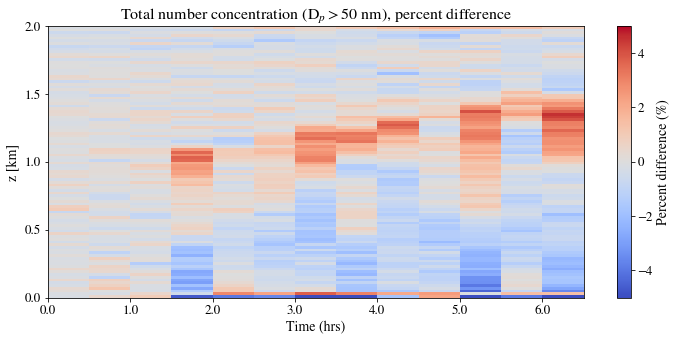

In [6]:
fig, ax  = plt.subplots(1,1, figsize=(12,5))
vmin, vmax = -5, 5
cs = ax.pcolormesh(rel_diff.T, cmap=plt.cm.coolwarm, vmin=vmin, vmax=vmax)
cbar = fig.colorbar(cs)
cbar.ax.tick_params(labelsize=13) 
cbar.set_label(f'Percent difference (%)', size=14)

n_times = rel_diff.shape[0]
delta_t = .5
ax.set_title('Total number concentration (D$_p > 50 $ nm), percent difference', fontsize=16)
ax.set_xlabel('Time (hrs)', fontsize=14)
ax.set_ylabel('z [km]', fontsize=14)
ax.set_xticks(np.linspace(0, n_times-1, 7))
ax.set_xticklabels(delta_t*np.linspace(0, n_times-1, 7), fontsize=13)
ax.set_yticks(np.arange(0, n_levels+1, 25))
ax.set_yticklabels(np.linspace(0, 2, 5).round(2), fontsize=13)

plt.savefig(f'./figures/updated-results/numconc-pdiff.pdf', format='pdf', bbox_inches='tight')